### 测试CUTE和Corrfunc差异

In [1]:
import numpy as np 
import joblib 

In [2]:
root_path = "/Raid6/1/xiaoliang/simulation/BIGMDPL/data/"

In [3]:
tpcf_corr = joblib.load(root_path + "tpCF-11_nbar1e-3.shiftz-nbar1e-3.x8ran0-150s0to150_120mu.pkl")

In [8]:
tpcf_corr["muedges"]

array([0.        , 0.00833333, 0.01666667, 0.025     , 0.03333333,
       0.04166667, 0.05      , 0.05833333, 0.06666667, 0.075     ,
       0.08333333, 0.09166667, 0.1       , 0.10833333, 0.11666667,
       0.125     , 0.13333333, 0.14166667, 0.15      , 0.15833333,
       0.16666667, 0.175     , 0.18333333, 0.19166667, 0.2       ,
       0.20833333, 0.21666667, 0.225     , 0.23333333, 0.24166667,
       0.25      , 0.25833333, 0.26666667, 0.275     , 0.28333333,
       0.29166667, 0.3       , 0.30833333, 0.31666667, 0.325     ,
       0.33333333, 0.34166667, 0.35      , 0.35833333, 0.36666667,
       0.375     , 0.38333333, 0.39166667, 0.4       , 0.40833333,
       0.41666667, 0.425     , 0.43333333, 0.44166667, 0.45      ,
       0.45833333, 0.46666667, 0.475     , 0.48333333, 0.49166667,
       0.5       , 0.50833333, 0.51666667, 0.525     , 0.53333333,
       0.54166667, 0.55      , 0.55833333, 0.56666667, 0.575     ,
       0.58333333, 0.59166667, 0.6       , 0.60833333, 0.61666

### 测试宇宙学转换函数核心速度

In [1]:
import numpy as np 
import math
from LSS_python.base import DA_jit, Hz_jit
from numba import njit 

In [2]:
@njit
def smu_cosmo_convert(s_f, mu_f, DA_f, DA_t, H_f, H_t):
    """s1: angular direction; s2: LOS direction
    f: fiducial; t: task
    """
    s2 = s_f * mu_f
    s1 = s_f * np.sqrt(1 - mu_f**2)
    alpha1 = DA_t / DA_f
    alpha2 = H_f / H_t
    s_t = np.sqrt((alpha1 * s1) ** 2 + (alpha2 * s2) ** 2)
    mu_t = alpha2 * s2 / (s_t + 1e-15)
    return s_t, mu_t

@njit
def smu_cosmo_convert_math(s_f, mu_f, DA_f, DA_t, H_f, H_t):
    """s1: angular direction; s2: LOS direction
    f: fiducial; t: task
    """
    s2 = s_f * mu_f
    s1 = s_f * math.sqrt(1 - mu_f**2)
    alpha1 = DA_t / DA_f
    alpha2 = H_f / H_t
    s_t = math.sqrt((alpha1 * s1) ** 2 + (alpha2 * s2) ** 2)
    mu_t = alpha2 * s2 / (s_t + 1e-15)
    return s_t, mu_t

In [3]:
DA_f = DA_jit(0.6, 0.3071, -1.0)
DA_t = DA_jit(0.6, 0.4071, -0.8)

Hz_f = Hz_jit(0.6, 0.3071, -1.0)
Hz_t = Hz_jit(0.6, 0.4071, -0.8)

In [4]:
s_f, mu_f = 10.0, 0.4
s_t1, mu_t1 = smu_cosmo_convert(s_f, mu_f, DA_f, DA_t, Hz_f, Hz_t)
s_t2, mu_t2 = smu_cosmo_convert_math(s_f, mu_f, DA_f, DA_t, Hz_f, Hz_t)

In [9]:
number = 50000 * 100

s_f_array = np.ones(number) * s_f
mu_f_array = np.ones(number) * mu_f
DA_f_array = np.ones(number) * DA_f
Hz_f_array = np.ones(number) * Hz_f
Hz_t_array = np.ones(number) * Hz_t
DA_t_array = np.ones(number) * DA_t

s_t_array, mu_t_array = smu_cosmo_convert(s_f_array, mu_f_array, DA_f_array, DA_t_array, Hz_f_array, Hz_t_array)

In [10]:
%%timeit -n 3 -r 5
s_t_array, mu_t_array = smu_cosmo_convert(s_f_array, mu_f_array, DA_f_array, DA_t_array, Hz_f_array, Hz_t_array)

181 ms ± 4.96 ms per loop (mean ± std. dev. of 5 runs, 3 loops each)


In [21]:
%%timeit -n 100 -r 5
s_t1, mu_t1 = smu_cosmo_convert(s_f, mu_f, DA_f, DA_t, Hz_f, Hz_t)

1.67 μs ± 102 ns per loop (mean ± std. dev. of 5 runs, 100 loops each)


In [22]:
%%timeit -n 100 -r 5
s_t2, mu_t2 = smu_cosmo_convert_math(s_f, mu_f, DA_f, DA_t, Hz_f, Hz_t)

1.62 μs ± 89 ns per loop (mean ± std. dev. of 5 runs, 100 loops each)


### 测试：积分函数

In [1]:
import numpy as np 
from LSS_python.base import traz 

In [2]:
x_array = np.linspace(0.0, 1*np.pi, 100)
V_array = np.sin(x_array)
print(traz(V_array, x_array))

1.9998321638939927


In [8]:
x_array = np.linspace(0, 2, 10)
y_array = np.linspace(0, 1, 10)
X_mesh, Y_mesh = np.meshgrid(x_array, y_array, indexing="ij")
V_array = X_mesh + Y_mesh
print(traz(V_array, x_array, y_array))

3.0


### 测试：寻找邻居构建MCF

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np 
from scipy.spatial import KDTree
from sklearn.neighbors import NearestNeighbors
from MCF import cal_rho_array, cal_rho, w_kernel

In [3]:
data = np.load("/Raid6/1b/xiaoliang/simulation/COLA/tpCF/LCDM_plank13_box1000_npar1024/halo_2_shiftz.npy")

In [4]:
boxsize = 1000.0
kdtree = KDTree(data, boxsize=None)
kdtree_result = kdtree.query(data, k=31, distance_upper_bound=30)

In [4]:
kdtree_result[0]

array([[ 0.        , 11.0385601 , 12.44208462, ...,         inf,
                inf,         inf],
       [ 0.        ,  1.27633405,  2.44308663, ...,         inf,
                inf,         inf],
       [ 0.        ,  1.20811361,  1.27633405, ...,         inf,
                inf,         inf],
       ...,
       [ 0.        ,  2.32409592,  5.57591046, ..., 22.79207145,
        22.98082245, 23.09866202],
       [ 0.        ,  1.25566053,  7.13560577, ..., 15.47875454,
        15.74954147, 16.18373074],
       [ 0.        ,  1.25566053,  8.35197004, ..., 16.2688897 ,
        16.5664349 , 16.59623687]])

In [5]:
rho_array_1 = cal_rho_array(kdtree_result[0], 15.0)

In [5]:
new_result = np.copy(kdtree_result[0])
new_result[np.isinf(new_result)] = 0.0

In [6]:
rho_array_2 = cal_rho_array(new_result, h=None, use_max_distance_as_h=True)

In [8]:
np.max(rho_array_1)

0.002806452408888902

In [7]:
np.max(rho_array_2)

3.2178659891309183

In [8]:
np.argmax(rho_array_2)

527616

In [9]:
test_array = new_result[527616]
h = np.max(test_array) / 2.0
for item in test_array:
    print(w_kernel(item, h))

0.0
0.3386353950755209
0.3276987994066367
0.30465644441320033
0.27292384163002437
0.22617299132301488
0.22005924137780372
0.2028193195489765
0.1987792646181191
0.1799662197018824
0.15286360534886936
0.13533156064922777
0.1254683527341903
0.12380026309021663
0.10296749511496255
0.0999797277384586
0.0697083485773174
0.05876485568716877
0.04682078416170166
0.010457570083572053
0.00575565456838483
0.004941321217487585
0.004801925395647695
0.0026567149879603274
0.0006907715979496981
0.0005856160990220412
0.0005515034918893084
4.022925496806105e-06
3.005811867078159e-06
1.3727543482606666e-06
0.0


In [10]:
new_result[527616]

array([0.        , 0.49785289, 0.51504562, 0.55103379, 0.60054181,
       0.674938  , 0.68492568, 0.71357819, 0.72041416, 0.75300284,
       0.8028623 , 0.83777844, 0.85871537, 0.86236371, 0.91096991,
       0.91846471, 1.00453267, 1.04181623, 1.08824296, 1.32029562,
       1.38491271, 1.39945881, 1.40210598, 1.45156323, 1.53358566,
       1.54133697, 1.54404988, 1.65226881, 1.65467946, 1.66011142,
       1.67830634])

### 测试：B样条插值函数性质

In [11]:
from MCF import w_kernel
from base import traz
import numpy as np
import matplotlib.pyplot as plt

In [12]:
x = np.linspace(0,10,1000)
y = np.zeros(1000)

for i in range(1000):
    y[i] = w_kernel(x[i], 5.0)

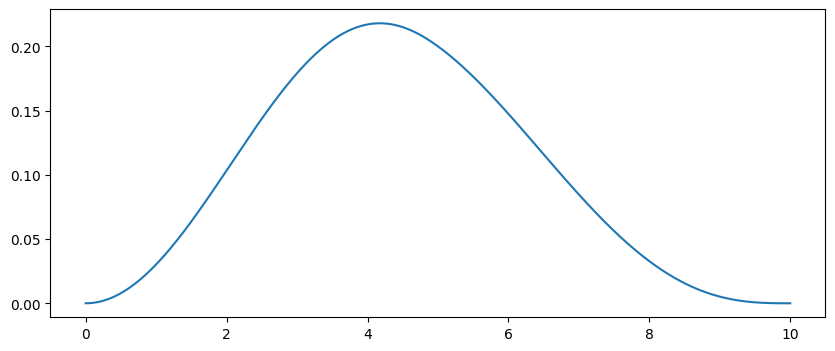

In [36]:
fig = plt.figure(dpi=100, figsize=(10,4))
plt.plot(x,y*4*np.pi*x**2)
plt.show()

In [9]:
traz(y * 4 * np.pi * x**2, x)

1.000000000001004

In [2]:
from MCF import cal_rho_array
import numpy as np 

In [15]:
distance_array = np.array([[1.0, 2.0, 4.0, 6.0, 10.0, 15.0, 25.0]*3, 
                            [0.1, 0.2, 3.0, 5.0, 8.0, 10.0, 25.0]*3])

In [16]:
test1 = cal_rho_array(distance_array, 15.0)
print(test1)
print(test1[0] / test1[1])

[0.00127297 0.00143132]
0.8893652448971467


In [17]:
test2 = cal_rho_array(distance_array, 15.0, True)
print(test2)
print(test2[0] / test2[1])

[0.0020123  0.00231637]
0.8687288077734915


### 测试：和霄栋程序比对

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.spatial import KDTree
from MCF import cal_rho_array

In [2]:
data = np.loadtxt("/Raid6/1/xiaoliang/AP_SysTest/no_error/11/11_nbar1e-3.shiftz.numNB30.margin30.00.boxsize2500.00", usecols=(0,1,2,3, 7), dtype=np.float32)

In [3]:
kdtree = KDTree(data[:,:3], boxsize=2500.00001)

In [4]:
result = kdtree.query(data[:,:3], k=30, workers=4)

In [24]:
rho_array_1 = cal_rho_array(result[0], h=15.0)

In [5]:
rho_array_2 = cal_rho_array(result[0], h=None, use_max_distance_as_h=True)

In [11]:
rho_diff = np.abs(rho_array_2 - data[:,3]) / data[:,3]

In [14]:
rho_array_2[11635385], data[11635385]

(0.006944564999304728,
 array([1.649590e+03, 1.807200e+03, 1.036378e+03, 4.613864e-03,
        1.708199e+01], dtype=float32))

In [16]:
result[0][11635385]

array([ 0.        ,  0.69110607,  1.48557591,  1.53849273,  3.72670703,
        4.45531767,  5.54754204,  5.70324914,  6.3145058 ,  7.19396082,
        7.3161547 ,  9.32262483,  9.3792178 ,  9.8703873 , 10.07878728,
       10.1284821 , 10.1397247 , 10.23131817, 11.00803391, 11.23779393,
       11.63617197, 11.90615272, 11.92339883, 12.33899976, 12.95179811,
       13.19823147, 13.25885542, 13.35740821, 13.42721398, 13.68411764])

In [18]:
result[1][11635385]

array([11635385,  4842161, 12019953, 15117531,  1464956, 11026159,
        5250874, 12717999, 12558578,  8339432,  2680504,  1763902,
        1458581,  8707740,  5075076,  4442086,  4080292,  9986510,
        3275667,  2031194,  9754804, 11956876,  1679109,  5352734,
        1606091,  1615725,  3843949,  5636992, 10285211,   173500])

In [25]:
result[0][6]

array([ 0.        ,  0.99441016,  2.28165814,  3.98553596,  4.13906364,
        4.51890682,  4.63917141,  5.60877648,  6.00639044,  6.21201024,
        6.32884083,  6.72885667,  6.75337787,  6.8314492 ,  7.6610031 ,
        8.10814599,  8.41088346,  8.48868327,  8.85338081,  9.1335584 ,
        9.37975213,  9.81318022, 10.03043017, 10.27811091, 10.34872493,
       10.36183734, 10.60363012, 10.6055239 , 10.88957277, 11.19794649])

In [19]:
result[1][4]

array([       4, 14595535, 12952946,   912174,  7434422,  8754480,
        7002900,  4879280,  1073795,  3511809, 14114663,  7726609,
         886193,   383362,  3096251, 13622008,  3827284,  7766690,
        6312866, 14836290,  6995536, 10764836, 11712761, 11919745,
       12159220,  3809302,  9801393,  3012254,  5710999,  6415659])

In [52]:
def cal_distance(data, index_array):
    distance_array = np.zeros(index_array.shape, dtype=np.float32)
    fuducial_pos = data[index_array[0]]
    for i in range(index_array.shape[0]):
        distance_temp = 0.0 
        for j in range(3):
            pos_diff = data[index_array[i]][j] - fuducial_pos[j]
            distance_temp += pos_diff * pos_diff
        distance_array[i] = np.sqrt(distance_temp)
    return distance_array

In [53]:
cal_distance(data[:,:3], result[1][0])

array([ 0.       ,  1.5781667,  2.3395114,  3.1305943,  3.525681 ,
        3.7073488,  3.8607461,  4.4709334,  6.526491 ,  6.6373944,
        6.830204 ,  7.0865097,  8.398026 ,  8.7853565,  9.939289 ,
       10.367059 , 11.337845 , 11.499579 , 12.129817 , 12.201879 ,
       12.232749 , 12.393038 , 12.41142  , 13.00485  , 13.273669 ,
       13.304365 , 13.345138 , 13.777317 , 13.835587 , 14.184428 ,
       14.376134 ], dtype=float32)

### 测试：加权关联函数对比

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from LSS_python.tpcf import xismu 

In [2]:
root_path = "/Raid6/1/xiaoliang/AP_SysTest/no_error/"
tpcf_CUTE_filenames = [root_path + "11/11_nbar1e-3.shiftz.numNB30.margin30.00.boxsize2500.00-zplus1000000-weipow1-150s0to150-120mu.2pcf", root_path + "26/26_nbar1e-3.shiftz.numNB30.margin30.00.boxsize2500.00-zplus1000000-weipow1-150s0to150-120mu.2pcf"]
tpcf_pkl_filename = [root_path + "11/tpCF-11_nbar1e-3.shiftz.numNB30-weipow1-150s0to150-120mu.pkl", root_path + "26/tpCF-26_nbar1e-3.shiftz.numNB30-weipow1-150s0to150-120mu.pkl"]
tpcf_CUTE_list = [xismu.load(tpcf_CUTE_filenames[i]) for i in range(2)]
tpcf_pkl_list = [xismu.load(tpcf_pkl_filename[i], data_type="BINARY") for i in range(2)]

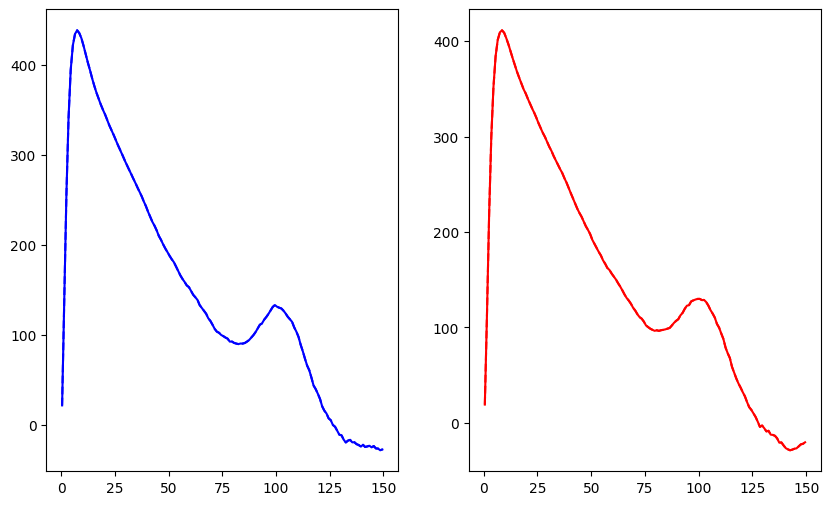

In [4]:
fig = plt.figure(dpi=100, figsize=(10, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
axes = [ax1, ax2]
colors = ["blue", "red"]
for i in range(2):
    s_CUTE, xis_s_CUTE = tpcf_CUTE_list[i].integrate_tpcf(smin=0.0, smax=150.0, s_xis=True, intximu=False, quick_return=True)
    s_pkl, xis_s_pkl = tpcf_pkl_list[i].integrate_tpcf(smin=0.0, smax=150.0, s_xis=True, intximu=False, quick_return=True)
    axes[i].plot(s_CUTE, xis_s_CUTE, color=colors[i])
    axes[i].plot(s_pkl, xis_s_pkl, color=colors[i], ls="--")
plt.show()

In [13]:
tpcf_pkl_list[0].S

array([[  0.5,   0.5,   0.5, ...,   0.5,   0.5,   0.5],
       [  1.5,   1.5,   1.5, ...,   1.5,   1.5,   1.5],
       [  2.5,   2.5,   2.5, ...,   2.5,   2.5,   2.5],
       ...,
       [147.5, 147.5, 147.5, ..., 147.5, 147.5, 147.5],
       [148.5, 148.5, 148.5, ..., 148.5, 148.5, 148.5],
       [149.5, 149.5, 149.5, ..., 149.5, 149.5, 149.5]])

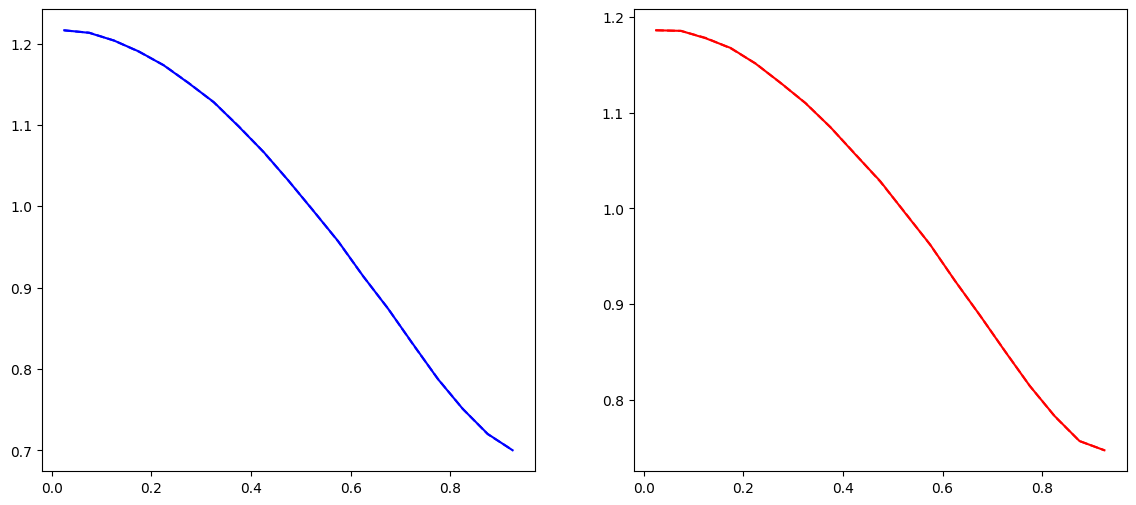

In [6]:
fig = plt.figure(dpi=100, figsize=(14, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
axes = [ax1, ax2]
colors = ["blue", "red"]
for i in range(2):
    mu_CUTE, xis_mu_CUTE = tpcf_CUTE_list[i].integrate_tpcf(mupack=6, is_norm=True, quick_return=True)
    mu_pkl, xis_mu_pkl = tpcf_pkl_list[i].integrate_tpcf(mupack=6, is_norm=True, quick_return=True)
    axes[i].plot(mu_CUTE, xis_mu_CUTE, color=colors[i])
    axes[i].plot(mu_pkl, xis_mu_pkl, color=colors[i], ls="--")
plt.show()

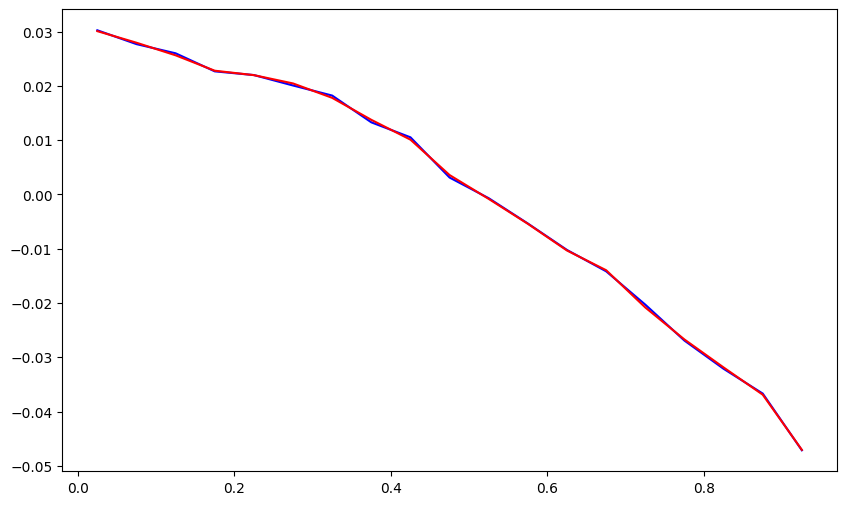

In [7]:
fig = plt.figure(dpi=100, figsize=(10, 6))
ax = fig.add_subplot(111)
axes = [ax1, ax2]
colors = ["blue", "red"]
xis_mu_CUTE_list = []
xis_mu_pkl_list = []
for i in range(2):
    mu_CUTE, xis_mu_CUTE = tpcf_CUTE_list[i].integrate_tpcf(mupack=6, is_norm=True, quick_return=True)
    mu_pkl, xis_mu_pkl = tpcf_pkl_list[i].integrate_tpcf(mupack=6, is_norm=True, quick_return=True)
    xis_mu_CUTE_list.append(xis_mu_CUTE)
    xis_mu_pkl_list.append(xis_mu_pkl)
ax.plot(mu_CUTE, xis_mu_CUTE_list[0] - xis_mu_CUTE_list[1], color=colors[0])
ax.plot(mu_pkl, xis_mu_pkl_list[0] - xis_mu_pkl_list[1], color=colors[1])
plt.show()

### 测试：numba的FFTPower 

In [1]:
import numpy as np 

from my_fft import FFTPower as FFTPower_old
from LSS_python.fftpower import FFTPower, deal_ps_3d

In [2]:
complex_field = np.load("/Raid6/1/xiaoliang/simulation/ska/data/snap100_myfft/mesh1024/mass_fftpower_mesh1024_all_complex/complex_field.npy")
kernel_field = np.load("/Raid6/1/xiaoliang/simulation/ska/data/mesh1024_all_complex_kernel1/complex_field.npy")
Nmesh = 1024 
boxsize = 1000.0 

In [7]:
complex_field_temp = np.copy(complex_field)
ps_3d = np.copy(complex_field)

In [4]:
complex_field_temp_kernel = complex_field_temp * kernel_field
fftpower_old = FFTPower_old(Nmesh, boxsize, shotnoise=0.0)
complex_field_temp_kernel = complex_field_temp_kernel * np.conj(complex_field_temp_kernel) * np.prod(fftpower_old.attrs["BoxSize"])
fftpower_old.is_run_ps_3d = True
_ = fftpower_old.run(complex_field_temp_kernel, 0.1, 3.1, 0.01, 50, mode="2d", run_ps_3d=False, nthreads=10)

In [8]:
fftpower_new = FFTPower(Nmesh, boxsize, shotnoise=0.0)
deal_ps_3d(ps_3d, ps_3d_kernel=kernel_field, ps_3d_factor=np.prod(fftpower_new.attrs["BoxSize"]), shotnoise=fftpower_new.attrs["shotnoise"], nthreads=10)
_ = fftpower_new.run(ps_3d, 0.1, 3.1, 0.01, 50, mode="2d", nthreads=10)

In [6]:
np.nansum(np.abs(fftpower_old.power["Pkmu"] - fftpower_new.power["Pkmu"]))

np.float64(4.057218621356175e-06)

### 测试：numba和cuda版本的FFTPower 

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np 
import cupy as cp 

from LSS_python.fftpower import FFTPower, deal_ps_3d
from LSS_python.cuda.fftpower import get_deal_ps_core_kernel, get_run_fftpower_core_kernel

In [3]:
complex_field = np.load("/Raid6/1/xiaoliang/simulation/ska/data/snap100_myfft/mesh1024/mass_fftpower_mesh1024_all_complex/complex_field.npy")
ps_3d_cpu = np.copy(complex_field)
ps_3d_gpu = cp.asarray(ps_3d_cpu)

In [4]:
fftpower_cpu = FFTPower(1024, 1000.0, 0.0)
deal_ps_3d(ps_3d_cpu, None, 1000.0**3, 0.0, nthreads=10)

In [5]:
_ = fftpower_cpu.run(
    ps_3d_cpu, 0.1, 3.1, 0.01, Nmu=50, mode="2d", linear=True, nthreads=10
)

In [6]:
%%timeit -n 5 -r 5 
_ = fftpower_cpu.run(
    ps_3d_cpu, 0.1, 3.1, 0.01, Nmu=50, mode="2d", linear=True, nthreads=10
)

1.29 s ± 8.87 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [6]:
deal_ps_core_kernel = get_deal_ps_core_kernel()
deal_ps_core_kernel.compile()
run_fftpower_core_kernel = get_run_fftpower_core_kernel()
run_fftpower_core_kernel.compile()

In [7]:
fftpower_gpu = FFTPower(1024, 1000.0, 0.0)
nx, ny, nz = ps_3d_gpu.shape
ps_3d_kernel_gpu = cp.array([0], dtype=cp.complex64)
deal_ps_core_kernel((nx,ny), (nz,), (ps_3d_gpu, ps_3d_kernel_gpu, nx, ny, nz, 1000.0**3, 0.0, False))
fftpower_gpu.run_from_cuda(
    run_fftpower_core_kernel,
    ps_3d_gpu,
    0.1, 3.1, 0.01, Nmu=50, mode="2d"
)
cp.cuda.Stream.null.synchronize()

In [15]:
%%timeit -n 5 -r 5 
fftpower_gpu.run_from_cuda(
    run_fftpower_core_kernel,
    ps_3d_gpu,
    0.1, 3.1, 0.01, Nmu=50, mode="2d"
)

count = 3758096392, 2
count = 3758096392, 2
count = 3758096392, 2
count = 3758096392, 2
count = 3758096392, 2
count = 3758096392, 2
count = 3758096392, 2
count = 3758096392, 2
count = 3758096392, 2
count = 3758096392, 2
count = 3758096392, 2
count = 3758096392, 2
count = 3758096392, 2
count = 3758096392, 2
count = 3758096392, 2
count = 3758096392, 2
count = 3758096392, 2
count = 3758096392, 2
count = 3758096392, 2
count = 3758096392, 2
count = 3758096392, 2
count = 3758096392, 2
count = 3758096392, 2
count = 3758096392, 2
count = 3758096392, 2
114 ms ± 42.7 μs per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [12]:
np.nanargmax(np.abs(fftpower_cpu.power["Pkmu"] - fftpower_gpu.power["Pkmu"]))

np.int64(116)

In [16]:
fftpower_cpu.power["modes"][2, 16]

np.uint64(20)

In [15]:
fftpower_gpu.power["modes"][2, 16]

np.uint32(32)

In [6]:
fftpower_cpu.power["modes"][2]

array([216,   0, 432,   0, 184, 224,   0, 408,   0, 208, 216,   0, 360,
        32, 184, 192,  32, 288, 104, 176, 200,  72, 216, 128, 184, 192,
       128, 208, 136, 176, 144, 176, 160, 168, 160, 128, 216, 152, 208,
       168, 104, 216,  96, 208, 144, 112, 232, 112, 184, 170],
      dtype=uint64)

In [9]:
fftpower_gpu.power["modes"][2]

array([216,   0, 432,   0, 184, 224,   0, 408,   0, 208, 216,   0, 360,
        32, 184, 192,  32, 288, 104, 176, 200,  72, 216, 128, 184, 192,
       128, 208, 136, 176, 144, 176, 160, 168, 160, 128, 216, 152, 208,
       168, 104, 216,  96, 208, 144, 112, 232, 112, 184, 170],
      dtype=uint32)

In [19]:
fftpower_cpu.power["modes"][3]

array([133,   0, 266,   0, 278,   0, 144, 142,   0, 234,   0, 246,  28,
       162, 112,  64, 194,   0, 304, 128, 208, 216, 120, 256, 112, 208,
       120, 224, 208, 168, 192, 224, 184, 168, 160, 168, 216, 144, 224,
       168, 240, 152, 168, 184, 144, 232, 112, 232, 160, 196],
      dtype=uint64)

In [20]:
fftpower_gpu.power["modes"][3]

array([212,   0, 424,   0, 440,   0, 216, 224,   0, 368,   0, 384,  48,
       256, 184, 104, 304,   0, 304, 128, 208, 216, 120, 256, 112, 208,
       120, 224, 208, 168, 192, 224, 184, 168, 160, 168, 216, 144, 224,
       168, 240, 152, 168, 184, 144, 232, 112, 232, 160, 196],
      dtype=uint32)

### 测试：ps_convert_main的CPU和GPU功能

In [1]:
import numpy as np
import cupy as cp 

from LSS_python.AP import ps_convert_main
from LSS_python.fftpower import deal_ps_3d, deal_ps_3d_from_cuda

In [2]:
device_id = 0
use_kernel = False 
complex_field = np.load("/Raid6/1/xiaoliang/simulation/ska/data/snap100_myfft/mesh1024/mass_fftpower_mesh1024_all_complex/complex_field.npy")
# kernel_field = np.load("/Raid6/1/xiaoliang/simulation/ska/data/mesh1024_all_complex_kernel1/complex_field.npy")
ps_3d_cpu = np.copy(complex_field)
# ps_kernel_3d_cpu = np.copy(kernel_field)
with cp.cuda.Device(device_id):
    ps_3d_gpu = cp.asarray(ps_3d_cpu)
    # ps_kernel_3d_gpu = cp.asarray(ps_kernel_3d_cpu)
if not use_kernel:
    ps_kernel_3d_cpu = None 
    ps_kernel_3d_gpu = None

In [5]:
deal_ps_3d(ps_3d_cpu, ps_kernel_3d_cpu, 1000.0**3, 0.0, nthreads=10)
fftpower_cpu = ps_convert_main(ps_3d_cpu, 0.3111, -1.0, 0.25, -1.4, 0.5, boxsize=1000.0, Nmesh=1024, k_min=0.1, k_max = 3.1, dk = 0.01, Nmu = 50, mode="2d", nthreads=10)

In [3]:
with cp.cuda.Device(device_id):
    deal_ps_3d_from_cuda(ps_3d_gpu, ps_kernel_3d_gpu, 1000.0**3, 0.0)

fftpower_gpu = ps_convert_main(ps_3d_gpu, 0.3111, -1.0, 0.25, -1.4, 0.5, boxsize=1000.0, Nmesh=1024, k_min=0.1, k_max = 3.1, dk = 0.01, Nmu = 50, mode="2d", device_id=device_id)

In [11]:
fftpower_gpu.power["modes"][-10]

array([ 98140,  96344,  97640,  98656,  99944, 102352, 105072, 108888,
       116480, 124588, 125120, 125176, 125480, 124968, 124672, 125224,
       125552, 124960, 125312, 125544, 125512, 125080, 125320, 124904,
       125064, 125336, 125240, 124984, 124992, 125304, 125176, 125048,
       125504, 124648, 125216, 125448, 125120, 125072, 125192, 124992,
       124888, 125656, 124928, 125112, 125064, 125400,  60224,      0,
            0,      0], dtype=uint32)

In [10]:
fftpower_cpu.power["modes"][-10]

array([ 98140,  96344,  97640,  98656,  99944, 102352, 105072, 108888,
       116480, 124588, 125120, 125176, 125480, 124968, 124672, 125224,
       125552, 124960, 125312, 125544, 125512, 125080, 125320, 124904,
       125064, 125336, 125240, 124984, 124992, 125304, 125176, 125048,
       125504, 124648, 125216, 125448, 125120, 125072, 125192, 124992,
       124888, 125656, 124928, 125112, 125064, 125400,  60224,      0,
            0,      0], dtype=uint64)

In [5]:
np.nansum(np.abs(fftpower_cpu.power["modes"] - cp.asnumpy(fftpower_gpu.power["modes"])))

np.uint64(0)

### 测试：numba版本的run_cic函数

In [1]:
import numpy as np 
from numba import njit 
from LSS_python.mesh import run_cic

from my_fft import Mesh 

In [2]:
pos = np.load("/Raid6/1/xiaoliang/AP_SysTest/data/11_nbar1e-3.shiftz.numNB30.npy")[:,:3]
struct_pos = np.empty(pos.shape[0], dtype=np.dtype([("Position", "float32", 3)]))
struct_pos["Position"] = pos

In [8]:
mesh = Mesh(256, 2500.0)
real_field = mesh.run_cic(struct_pos, field_dtype=np.float32, nthreads=10)

In [9]:
real_field_numba = np.zeros((256, 256, 256), dtype=np.float32)
run_cic(pos, real_field_numba, np.array([2500.0] * 3), np.array([256]*3, dtype=np.int64))

In [5]:
real_field_numba[0,0]

array([126.94786 , 129.86403 , 150.2515  , 190.74274 , 143.54372 ,
       115.67989 ,  70.903656,  81.55252 ,  96.41311 ,  59.35935 ,
        60.87677 , 188.61066 , 107.72917 ,  86.72349 , 106.56098 ,
       172.04427 , 239.21622 , 173.68716 ,  83.22322 , 138.33684 ,
       138.63982 , 118.98805 , 123.8032  , 110.22647 , 145.77559 ,
       164.63188 ,  85.77486 , 109.25189 , 144.78152 , 131.37888 ,
       128.7141  , 110.37267 ,  79.21247 ,  69.26166 ,  93.65241 ,
        75.967575, 126.4091  , 215.97528 , 250.51453 , 196.19948 ,
        88.78135 , 101.352585, 129.88208 , 160.151   ,  73.57452 ,
        88.40904 , 135.4199  ,  87.44953 , 108.483505, 120.393265],
      dtype=float32)

In [10]:
np.mean(np.abs(real_field - real_field_numba))

np.float32(3.7665975e-06)

### 测试：cuda版本的CIC

In [1]:
import numpy as np 
import cupy as cp 
from LSS_python.mesh import run_cic, run_cic_from_cuda

In [2]:
pos = np.load("/Raid6/1/xiaoliang/AP_SysTest/data/11_nbar1e-3.shiftz.numNB30.npy")[:,:3]

In [3]:
Nmesh = 256
real_field_numba = np.zeros((Nmesh, Nmesh, Nmesh), dtype=np.float32)
run_cic(pos, real_field_numba, np.array([2500.0] * 3), np.array([Nmesh]*3, dtype=np.int64))

In [3]:
Nmesh = 256
real_field_numba = np.zeros((Nmesh, Nmesh, Nmesh), dtype=np.float32)
real_field = run_cic_from_cuda(cp.asarray(pos), cp.array([2500.0] * 3), cp.array([Nmesh]*3, dtype=cp.int64))

TypeError: 'ndarray' object cannot be interpreted as an integer

In [5]:
test = cp.array(cp.array([Nmesh]*3, dtype=cp.int64))

In [9]:
cp.zeros((5,5), dtype=cp.float32)

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]], dtype=float32)